# Clustering and Deep Learning Practice

An airline company would like to know more about their customers and how to please them. They have provided some information about 20,000 customers as well as the results of a satisfaction survey. The data is available here: https://docs.google.com/spreadsheets/d/e/2PACX-1vSAUJiI10coRG2ZgJ_H6PJkPuIfr-tYVRRX9wtJvAyI_SHnAjvbd7RZHifP6XoeSS9HPNp38IfzPzIY/pub?output=csv

They would like you to:

1. Segment the customers into groups and describe those groups, what they have in common and how they differ.


2. Model the data to see if overall customer satisfaction can be predicted by information about their flights and answers to the survey other than overall satisfaction.

# Preliminary Steps

In [21]:
# import libraries

# general
import pandas as pd
import numpy as np

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator

# PCA
from sklearn.decomposition import PCA

# deep learning
from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# plotting
import matplotlib.pyplot as plt

In [2]:
# load data
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSAUJiI10coRG2ZgJ_H6PJkPuIfr-tYVRRX9wtJvAyI_SHnAjvbd7RZHifP6XoeSS9HPNp38IfzPzIY/pub?output=csv")

In [3]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Age                                20000 non-null  int64
 1   Class                              20000 non-null  int64
 2   Flight Distance                    20000 non-null  int64
 3   Inflight wifi service              20000 non-null  int64
 4   Departure/Arrival time convenient  20000 non-null  int64
 5   Ease of Online booking             20000 non-null  int64
 6   Gate location                      20000 non-null  int64
 7   Food and drink                     20000 non-null  int64
 8   Online boarding                    20000 non-null  int64
 9   Seat comfort                       20000 non-null  int64
 10  Inflight entertainment             20000 non-null  int64
 11  On-board service                   20000 non-null  int64
 12  Leg room service  

In [4]:
# make all lowercase
df = df.applymap(lambda x: x.lower() if type(x) == str else x)

In [5]:
# drop any duplicates
df.drop_duplicates(inplace = True)

# check
df.duplicated().sum()

0

In [6]:
# determine number of missing values
df.isna().sum()

# no missing values

Age                                  0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
Gender_Male                          0
Loyal Customer                       0
Business Travel                      0
satisfied                            0
dtype: int64

In [7]:
# inspect data (all dtypes are int64)

df.describe()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,39.477250,2.027800,1188.548000,2.727950,3.056100,2.751100,2.971350,3.202100,3.255300,3.439100,...,3.623650,3.302850,3.635550,3.282650,14.318350,14.698250,0.490650,0.817850,0.687900,0.43305
std,15.108901,0.963054,1001.136957,1.326886,1.531134,1.396799,1.279575,1.332383,1.348485,1.323434,...,1.186837,1.259131,1.184017,1.311734,36.451829,36.899857,0.499925,0.385978,0.463362,0.49551
min,7.000000,1.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,27.000000,1.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.00000
50%,40.000000,2.000000,842.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,...,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.00000
75%,51.000000,3.000000,1733.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,...,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000,1.000000,1.000000,1.000000,1.00000
max,85.000000,3.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,1305.000000,1280.000000,1.000000,1.000000,1.000000,1.00000


In [8]:
# no need for a preprocessor object; all data only needs to be scaled

scaler = StandardScaler()

# Part 1: Clustering

No need to split into X/y or train/test split because clustering is an unsupervised machine learning technique.

In [9]:
# create copy of data to use for part 1
df1 = df.copy()

In [10]:
# scale all data with scaler
scaled_data = scaler.fit_transform(df1)

# check
scaled_data[:5]

array([[-0.89202959,  1.00952182,  0.87248186, -0.54862899, -0.03664044,
         0.17819765,  0.02239081, -0.90224064, -0.93091953, -1.0874252 ,
        -1.01183883, -0.30142697, -0.2664881 , -0.52548564, -0.24052902,
        -0.5367878 , -0.97785257, -0.39281178, -0.39833806, -0.98147162,
         0.47193019,  0.67357232, -0.87397023],
       [ 0.82885333,  1.00952182, -0.50798316,  1.71236004,  1.26961399,
         1.61007909,  1.58544941, -0.15168691,  0.55226303,  0.42383211,
         0.48818167,  0.48078913,  0.49306184,  0.3171114 ,  0.55368931,
         0.30781577,  0.54688539,  0.10100294, -0.34413595, -0.98147162,
         0.47193019,  0.67357232,  1.14420373],
       [-0.75965398, -1.06725625, -0.9994367 ,  0.20503402,  1.26961399,
         0.17819765,  0.80392011, -0.15168691, -0.18932825, -0.33179654,
        -0.26182858, -0.30142697, -0.2664881 ,  0.3171114 ,  0.55368931,
         1.15241934, -0.21548359, -0.39281178, -0.39833806,  1.01887816,
         0.47193019, -1.4846

## Find optimal number of clusters

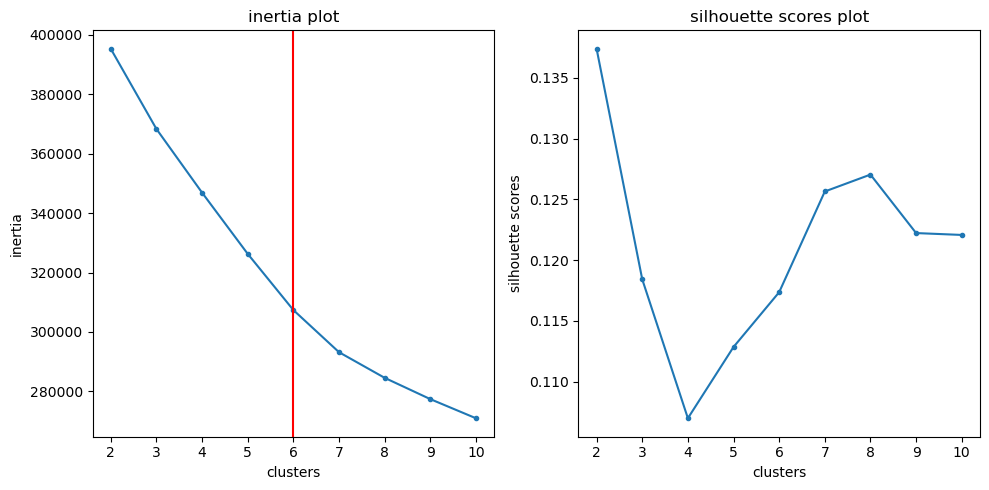

In [11]:
# create empty lists for inertias and silhouette scores
inertias = []
silhouette_scores = []

# look through k values 2-10 and store inertias and silhouette_scores
for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))
    
# visualize plots
fig, axes = plt.subplots(ncols = 2, figsize = (10, 5))

# inertia
axes[0].set_title('inertia plot')
axes[0].plot(range(2, 11), inertias, marker = '.')
axes[0].set_ylabel('inertia')
axes[0].set_xlabel('clusters')

# find the knee point for inertia plot
knee_locator = KneeLocator(range(2, 11), 
                           inertias,
                           curve = 'convex',
                           direction = 'decreasing',
                           interp_method = 'polynomial')
knee = knee_locator.knee
axes[0].axvline(x = knee, color = 'red')

# silhouette scores
axes[1].set_title('silhouette scores plot')
axes[1].plot(range(2, 11), silhouette_scores, marker = '.')
axes[1].set_ylabel('silhouette scores')
axes[1].set_xlabel('clusters')

fig.tight_layout();

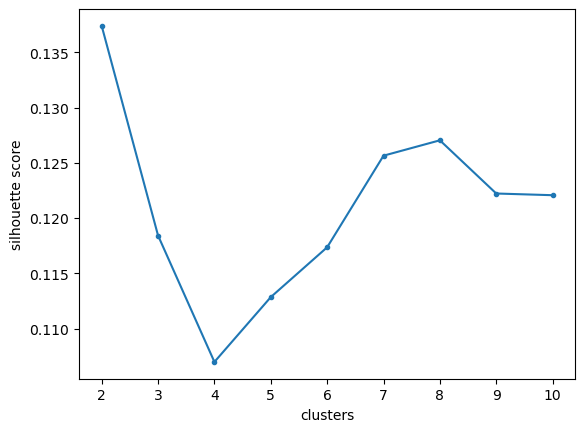

In [28]:
# visualize silhouette scores
plt.plot(range(2, 11), silhouette_scores, marker = '.')
plt.xlabel('clusters')
plt.ylabel('silhouette score')
plt.xticks(range(2, 11))
plt.show();

The knee locator on the inertia plot indicates that 6 clusters is the ideal knee point of the plot. Visually, I can also see a slight knee in the plot at 7 clusters. Any number of clusters before 6 or after 7 does not seem to be an inflection point in the plot.

The silhouette scores plot indicates that 2 clusters would be a good number for this data, and the second-best would be 7 or 8, both of which have significantly lower silhouette scores than 2, but comparable silhouette scores to each other. 

Seven clusters seems to be a compromise number between the inertia and silhouette scores plot. The inertia plot suggests 6 or 7, and the silhouette scores plot suggests 2, 8, or possibly 7. So, I will proceed with 7 clusters for this analysis.

In [12]:
# instantiate model with 7 clusters
kmeans = KMeans(n_clusters = 7, random_state = 42)
kmeans.fit(scaled_data)

# add clusters as column in df1
df1['cluster'] = kmeans.labels_

# check
df1.head(10)

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied,cluster
0,26,3,2062,2,3,3,3,2,2,2,...,3,3,2,0,0,0,1,1,0,3
1,52,3,680,5,5,5,5,3,4,4,...,4,4,4,18,2,0,1,1,1,1
2,28,1,188,3,5,3,4,3,3,3,...,4,5,3,0,0,1,1,0,0,0
3,54,3,453,3,5,5,5,3,4,4,...,4,3,1,91,80,0,1,1,0,4
4,40,1,775,4,3,3,3,4,4,4,...,3,3,4,0,0,1,1,1,0,4
5,79,3,2727,5,1,1,1,4,4,4,...,2,5,3,0,0,0,1,1,0,5
6,41,1,1192,2,4,2,3,3,2,3,...,4,4,3,2,0,0,1,0,0,0
7,24,3,1506,0,0,0,4,4,0,4,...,3,4,4,0,0,0,0,1,1,2
8,49,1,680,5,5,5,5,5,5,5,...,2,3,5,0,0,1,1,1,1,1
9,40,1,488,2,4,2,2,4,2,2,...,4,5,4,1,0,0,1,0,0,0


## Analysis of clusters

Describe each cluster.
How are the clusters different?

In [14]:
# look at aggregate means by cluster in table form
# as_index = False makes clusters a column instead of the index
cluster_groups = df1.groupby('cluster', as_index = False).mean()
cluster_groups

,cluster,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Gender_Male,Loyal Customer,Business Travel,satisfied
0,0,38.269656,1.212855,761.689387,2.406577,3.790135,2.349178,2.921973,3.849626,2.709118,...,3.886697,3.429297,3.964723,3.880717,10.159641,10.404484,0.505830,0.997608,0.018834,0.057997
1,1,42.174108,2.593092,1506.072452,4.422634,4.228587,4.291210,4.171862,3.666667,4.178602,...,4.067678,3.587195,4.051390,3.848076,8.846111,8.774502,0.519798,0.907329,0.944117,0.932322
2,2,29.838191,1.667839,681.405528,2.427136,2.128141,2.378894,2.974874,3.906533,2.411055,...,3.590955,3.108040,3.614573,3.928141,10.148241,10.457789,0.436181,0.023618,0.994975,0.138693
3,3,32.041745,1.566230,824.968691,2.404870,3.026224,2.639550,2.958255,1.553653,2.340380,...,3.698689,3.119615,3.739096,1.544287,10.192400,10.708322,0.560610,0.676478,0.561948,0.134600
4,4,47.108282,2.087730,1267.478834,2.435890,2.878834,2.680061,2.820552,3.087423,3.336810,...,2.143252,2.737730,2.131288,3.010123,11.111043,11.798466,0.393252,0.986196,0.708589,0.215951
5,5,44.264731,2.860653,1855.109746,2.106674,1.899749,1.978498,1.944429,3.592572,4.191008,...,4.219771,3.723262,4.240436,3.862608,8.670762,8.852834,0.493158,0.997207,0.998045,0.968724
6,6,38.304183,1.982890,1228.043726,2.771863,3.144487,2.781369,3.163498,3.038023,3.296578,...,3.652091,3.252852,3.275665,3.300380,181.228137,184.264259,0.492395,0.813688,0.701521,0.370722


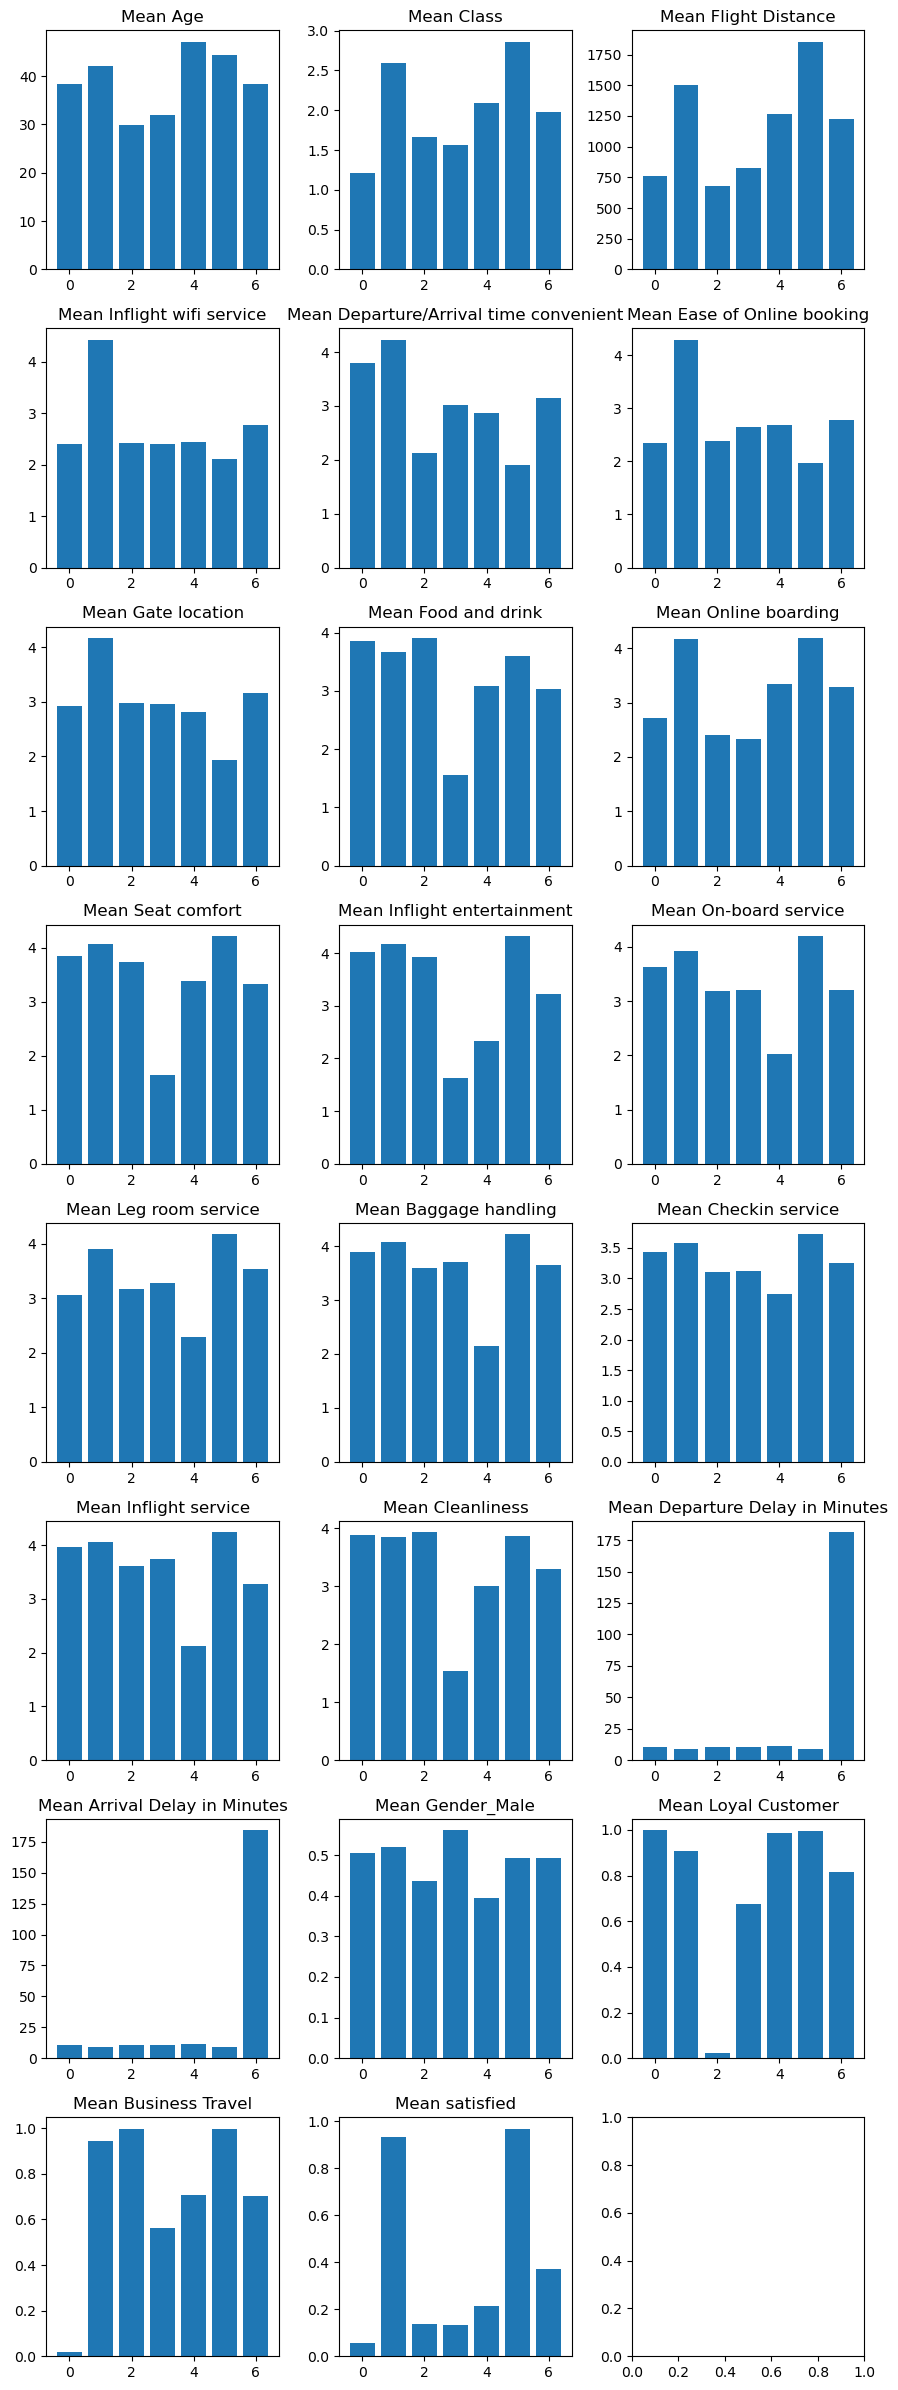

In [15]:
# visualize the clusters' aggregate means with bar charts
# 24 columns
fig, axes = plt.subplots(8, 3, figsize = (9, 24))

# axes.ravel() flattens array
axes = axes.ravel()

# loop over columns and plot each; skip 'cluster' column
for i, col in enumerate(cluster_groups.columns[1:]):
    axes[i].bar(cluster_groups['cluster'], cluster_groups[col])
    axes[i].set_title(f"Mean {col}")

plt.tight_layout();

### Cluster 0: ""

### Cluster 1: ""

### Cluster 2: ""

### Cluster 3: ""

### Cluster 4: ""

### Cluster 5: ""

### Cluster 6: "Delayed Customers"

Cluster 6 includes customers who were significantly delayed in their departure and arrival times compared to other customers. The mean departure and arrival times for these customers is over 175 minutes (about 3 hours), while the means for all other clusters are under 25 minutes.

## Visualizations of clusters

Create 2 report quality explanatory visualizations showing important differences between the clusters.
Interpret and explain each visualization.

# Part 2: Deep Learning

## Split data for supervised modeling

In [13]:
# create copy of df to use for part 2
df2 = df.copy()

In [16]:
# split into target (y) and features (X)
target = 'satisfied'
y = df2[target]
X = df2.drop(columns = target)

# check
print(f"y:\n{y}")
print(f"X:\n{X}")

y:
0        0
1        1
2        0
3        0
4        0
        ..
19995    1
19996    0
19997    0
19998    0
19999    0
Name: satisfied, Length: 20000, dtype: int64
X:
       Age  Class  Flight Distance  Inflight wifi service  \
0       26      3             2062                      2   
1       52      3              680                      5   
2       28      1              188                      3   
3       54      3              453                      3   
4       40      1              775                      4   
...    ...    ...              ...                    ...   
19995   10      2              820                      5   
19996   27      3             2676                      4   
19997   39      1              197                      2   
19998   17      3             3340                      2   
19999   40      3             3523                      4   

       Departure/Arrival time convenient  Ease of Online booking  \
0                          

In [18]:
# train/test split for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# check
print(f"shape of X_train: {X_train.shape}")
print(f"shape of X_test: {X_test.shape}")
print(f"shape of y_train: {y_train.shape}")
print(f"shape of y_test: {y_test.shape}")

shape of X_train: (15000, 22)
shape of X_test: (5000, 22)
shape of y_train: (15000,)
shape of y_test: (5000,)


## PCA

In [25]:
len(X.columns)

22

We have 23 features (dimensions) in our data. We want to speed up the machine learning models we will use, so we will reduce this number using PCA, while retaining the core variance in our data.

In [26]:
# scale df for PCA, a distance-based algorithm
scaler = StandardScaler()

# fit and transform on df2
scaled_data = scaler.fit_transform(X)

# instantiate and fit PCA
pca = PCA()
pca.fit(scaled_data)

PCA()

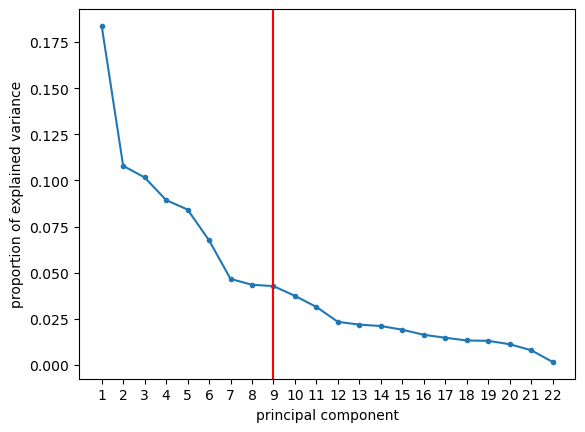

In [32]:
# locate knee with KneeLocator
knee_locator = KneeLocator(range(1, 23),
                          pca.explained_variance_ratio_,
                          curve = 'convex',
                          direction = 'decreasing', 
                          interp_method = 'polynomial')
knee = knee_locator.knee

# visualize individual contribution of each PC with scree plot
plt.plot(range(1, 23), pca.explained_variance_ratio_, marker = '.')
plt.xticks(ticks = range(1, 23), fontsize = 10)
plt.xlabel('principal component')
plt.ylabel('proportion of explained variance')
plt.axvline(x = knee, color = 'red')
plt.show();

The knee locator function indicates a knee in the plot at 9 PCs. To confirm this is a good number of PCs to go with, I will look at the cumulative variance each number of PCs would explain.

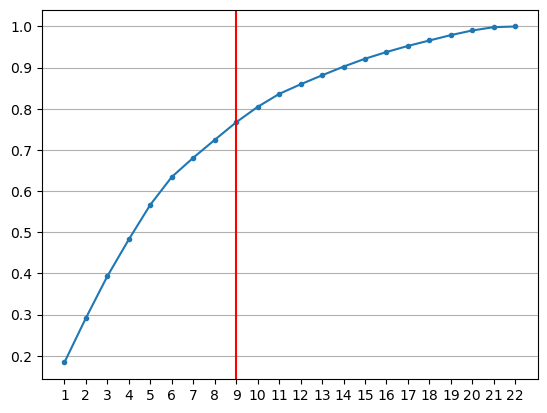

1 PCs explain 18.37% of variance
2 PCs explain 29.16% of variance
3 PCs explain 39.32% of variance
4 PCs explain 48.26% of variance
5 PCs explain 56.68% of variance
6 PCs explain 63.44% of variance
7 PCs explain 68.1% of variance
8 PCs explain 72.45% of variance
9 PCs explain 76.72% of variance
10 PCs explain 80.47% of variance
11 PCs explain 83.61% of variance
12 PCs explain 85.95% of variance
13 PCs explain 88.14% of variance
14 PCs explain 90.25% of variance
15 PCs explain 92.16% of variance
16 PCs explain 93.79% of variance
17 PCs explain 95.27% of variance
18 PCs explain 96.6% of variance
19 PCs explain 97.91% of variance
20 PCs explain 99.03% of variance
21 PCs explain 99.83% of variance
22 PCs explain 100.0% of variance


In [47]:
# see how much variance 9 PCs will explain
plt.plot(range(1, 23), pca.explained_variance_ratio_.cumsum(), marker = '.')
plt.xticks(ticks = range(1, 23), fontsize = 10)
plt.axvline(x = 9, color = 'red')
plt.grid(axis = 'y')
plt.show();

num_pcs = 1
for val in pca.explained_variance_ratio_.cumsum():
    print(f"{num_pcs} PCs explain {round((val * 100), 2)}% of variance")
    num_pcs += 1

9 PCs explain 76.72% of variance in this data. That seems a bit low, so I will actually instantiate a PCA with 12 PCs, which looks like another knee point on the scree plot above and explains 85.95% of variance. This still cuts our dimensions down by about half, and should be helpful for model speed.

## Deep learning modeling

### Transform data

In [49]:
# create a transformer that will scale and implement PCA

# scaler
scaler = StandardScaler()

# PCA with 12 components
pca12 = PCA(n_components = 12)

# transformer pipeline
transformer = make_pipeline(scaler, pca12)

# fit on training data
transformer.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=12))])

### Model 1

### Model 2

### Model 3